In [26]:
import json
import glob
import numpy as np
import matplotlib 
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
patches = [json.load(open(x)) for x in glob.glob('patch*.json')]
grouped_patches = {x[0]['value']['name']:{p['path']:p for p in x if p['op'] == 'add'} for x in patches if 'value' in x[0]}


In [28]:
def handle_deltas(delta_up, delta_dn):
    nom_is_center = np.bitwise_or(
        np.bitwise_and(delta_up > 0, delta_dn > 0),
        np.bitwise_and(delta_up <= 0, delta_dn <= 0)
    )
    span    = (delta_dn + delta_up)
    maxdel  = np.maximum(np.abs(delta_dn),np.abs(delta_dn))
    abs_unc = np.where(nom_is_center, span, maxdel)
    return abs_unc

def process_patch(p):
    nom = np.asarray(p['value']['data'])


    #histosys
    hid = np.asarray([m['data']['hi_data'] for m in p['value']['modifiers'] if m['type'] == 'histosys'])
    lod = np.asarray([m['data']['lo_data'] for m in p['value']['modifiers'] if m['type'] == 'histosys'])
    delta_up = hid-nom
    delta_dn = nom-lod
    A = handle_deltas(delta_up,delta_dn)

    hi = np.asarray([m['data']['hi'] for m in p['value']['modifiers'] if m['type'] == 'normsys'])
    lo = np.asarray([m['data']['lo'] for m in p['value']['modifiers'] if m['type'] == 'normsys'])
    delta_up = np.asarray([h*nom-nom for h in hi])
    delta_dn = np.asarray([l*nom-nom for l in lo])
    B = handle_deltas(delta_up,delta_dn)


    delta = np.asarray([m['data'] for m in p['value']['modifiers'] if m['type'] == 'staterror'])
    delta_up = (delta/2.)
    delta_dn = (delta/2.)
    C = handle_deltas(delta_up,delta_dn)
    C = np.zeros_like(A)

    systs = np.concatenate([A,B,C])
    inquad = np.sqrt(np.sum(np.square(systs), axis=0))
    rel =  inquad/nom
    rel = np.where(nom == 0, np.ones_like(nom), rel)
    return rel,nom

process_patch(grouped_patches['C1N2_Wh_hbb_1000_0']['/channels/2/samples/9'])

(array([0.28596541]), array([0.21570382]))

In [29]:
data = {x[0]['value']['name']:{p['path']:process_patch(p) for p in x if p['op'] == 'add'} for x in patches if 'value' in x[0]}
#print(data)

channel_names = {
    '/channels/0/samples/9': 'Region_0',
    '/channels/1/samples/9': 'Region_1',
    '/channels/2/samples/9': 'Region_2',
    '/channels/3/samples/9': 'Region_3',
    '/channels/4/samples/9': 'Region_4',
    '/channels/5/samples/7': 'Region_5',
    '/channels/6/samples/8': 'Region_6',
    '/channels/7/samples/9': 'Region_7', 
}

outliers = []
for k,v in data.items():
    for kk,vv in v.items():
        for b,(r,n) in enumerate(zip(*vv)):
            if r > 1.0:
                outliers.append((k,kk,b,r,n))

print("Outliers (> 1.0):")
for o in list(reversed(sorted(outliers, key = lambda x: x[-1]))):
    print('\t',o[-1],o[-2],o[0],channel_names[o[1]],o[2])
"""
missing_signal = []
# missing signal in signal region
print("Missing signal in signal region:")
for k, v in data.items():
    if not '/channels/2/samples/5' in v or not '/channels/2/samples/5' in v:
        missing_signal.append(k)
        print('\t',k)
"""

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


Outliers (> 1.0):
	 5.788952350616455 1.1551754007081005 C1N2_Wh_hbb_250_25 Region_6 0
	 3.522380828857422 1.11568936861988 C1N2_Wh_hbb_250_75 Region_6 1
	 3.447413682937622 1.1297204141273183 C1N2_Wh_hbb_225_25 Region_3 0
	 3.367600202560425 1.2228706027470773 C1N2_Wh_hbb_250_25 Region_3 0
	 3.347358226776123 1.0696618372905167 C1N2_Wh_hbb_325_0 Region_5 0
	 3.0724899768829346 1.3264989961059148 C1N2_Wh_hbb_165_35 Region_4 0
	 2.9465391635894775 1.0626099061709735 C1N2_Wh_hbb_250_100 Region_7 0
	 2.808008909225464 1.134483043245875 C1N2_Wh_hbb_400_100 Region_6 1
	 2.3863718509674072 1.0608479183987685 C1N2_Wh_hbb_300_75 Region_3 0
	 2.384101629257202 1.318296045152226 C1N2_Wh_hbb_225_0 Region_4 0
	 2.3368895053863525 1.01718010256837 C1N2_Wh_hbb_175_25 Region_4 0
	 2.2455739974975586 1.11854438543761 C1N2_Wh_hbb_200_50 Region_4 0
	 2.1425201892852783 2.6334475820631025 C1N2_Wh_hbb_175_0 Region_4 0
	 2.0894148349761963 2.1390574711348926 C1N2_Wh_hbb_200_25 Region_4 0
	 2.06902122497558

	 0.033178165555000305 1.4200731772398207 C1N2_Wh_hbb_800_50 Region_3 0
	 0.032932814210653305 2.191727947036995 C1N2_Wh_hbb_900_350 Region_3 0
	 0.0323086716234684 2.0036779119299766 C1N2_Wh_hbb_300_150 Region_5 2
	 0.02873409539461136 1.4504085729600469 C1N2_Wh_hbb_800_150 Region_4 0
	 0.028731679543852806 1.2799617225146354 C1N2_Wh_hbb_1000_300 Region_6 1
	 0.028262417763471603 4.122938299206647 C1N2_Wh_hbb_750_100 Region_4 0
	 0.026995480060577393 2.370093103274103 C1N2_Wh_hbb_900_100 Region_7 0
	 0.026719290763139725 2.0284762876484406 C1N2_Wh_hbb_900_400 Region_3 0
	 0.023146294057369232 1.045098196986588 C1N2_Wh_hbb_1000_150 Region_7 0
	 0.022828832268714905 1.6563058325807576 C1N2_Wh_hbb_1000_350 Region_7 0
	 0.019789066165685654 1.3341864894773896 C1N2_Wh_hbb_1000_300 Region_3 0
	 0.018754690885543823 1.2496979226509923 C1N2_Wh_hbb_1000_100 Region_7 0
	 0.018741553649306297 3.3246066221940183 C1N2_Wh_hbb_900_50 Region_6 0
	 0.018347250297665596 1.663340943501758 C1N2_Wh_hbb_10

'\nmissing_signal = []\n# missing signal in signal region\nprint("Missing signal in signal region:")\nfor k, v in data.items():\n    if not \'/channels/2/samples/5\' in v or not \'/channels/2/samples/5\' in v:\n        missing_signal.append(k)\n        print(\'\t\',k)\n'

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


[[1.00000000e+03 0.00000000e+00 3.74619768e+00]
 [1.00000000e+03 1.00000000e+02 1.70098966e+00]
 [1.00000000e+03 1.50000000e+02 1.54495711e-01]
 [1.00000000e+03 2.00000000e+02 4.00339916e+00]
 [1.00000000e+03 2.50000000e+02 6.49524672e-01]
 [1.00000000e+03 3.00000000e+02 0.00000000e+00]
 [1.00000000e+03 3.50000000e+02 1.84461187e-01]
 [1.00000000e+03 4.00000000e+02 0.00000000e+00]
 [1.00000000e+03 5.00000000e+01 2.56888410e-01]
 [1.50000000e+02 0.00000000e+00 2.37991075e-01]
 [1.65000000e+02 3.50000000e+01 8.08098243e-01]
 [1.75000000e+02 0.00000000e+00 1.98786864e+00]
 [1.75000000e+02 2.50000000e+01 1.41378396e+00]
 [1.90000000e+02 6.00000000e+01 3.66901731e-01]
 [2.00000000e+02 0.00000000e+00 1.10081693e+00]
 [2.00000000e+02 2.50000000e+01 2.33201599e-01]
 [2.00000000e+02 5.00000000e+01 2.03213843e+00]
 [2.25000000e+02 0.00000000e+00 1.06421898e+00]
 [2.25000000e+02 2.50000000e+01 3.93670467e-01]
 [2.25000000e+02 5.00000000e+01 1.35240712e-01]
 [2.50000000e+02 0.00000000e+00 2.200939

IndexError: too many indices for array

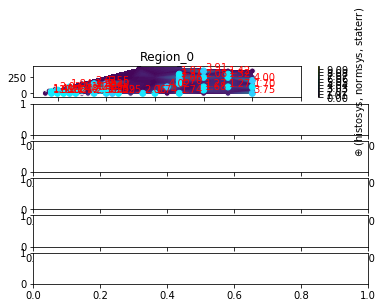

In [71]:
import scipy.interpolate
data = {x[0]['value']['name']:{p['path']:process_patch(p)[0] for p in x if p['op'] == 'add'} for x in patches if 'value' in x[0]}

f,axarr = plt.subplots(6,1)
#'/channels/5/samples/7'
#'/channels/6/samples/8'
for ichan, channel in enumerate(['/channels/0/samples/9', '/channels/5/samples/7']):#'/channels/0/samples/9','/channels/1/samples/9', '/channels/2/samples/9', '/channels/3/samples/9', '/channels/4/samples/9', '/channels/7/samples/9']):
    what = np.asarray(
        [[float(x.replace('p','.')) for x in k.split('hbb')[-1].split('_')[1:3]] + v.get(channel, np.array([0.0])).tolist() for k,v in data.items()
        ]
    )
    print(what)
    x,y = np.mgrid[100:1200:100j,0:400:100j]
    for jbin in range(2,3):
        what = what[what[:, jbin] != 0]
        z = scipy.interpolate.griddata(what[:,:2],what[:,jbin],(x,y))
        #print(what)
        
        vmin,vmax = 0, 10#np.log(0.001),np.log(20)
        #vmin, vmax = None, None
        #z = np.log(z)
        axarr[ichan].scatter(what[:,0],what[:,1], c = what[:,jbin], edgecolors='w')#, vmin = vmin, vmax = vmax)
        im = axarr[ichan].contourf(x,y,z, levels = np.linspace(vmin,vmax,100))
        #f.colorbar(im, cax=axarr[ichan][1])
        f.colorbar(im, ax=axarr[ichan], label='$\oplus$ (histosys, normsys, staterr)')
        axarr[ichan].set_title(channel_names[channel])
        
        out_here = np.asarray(
            [list(map(lambda x: float(x.replace('p','.')),o[0].split('hbb')[-1].split('_')[1:3])) + [o[-2]] for o in outliers
             if o[1] == channel and o[2] == jbin-2]
        )
        #print(out_here)
        
        #print(out_here.shape)
        if out_here.shape[0]:
            axarr[ichan].scatter(out_here[:,0],out_here[:,1], c = out_here[:,2], vmin = 0, vmax = 20, cmap = 'cool')
        for o in out_here:
            axarr[ichan].text(o[0]+5,o[1]+5,'{:.2f}'.format(o[2]), c='r')
    

f.set_size_inches(15,30)
f.savefig('plot.png')
#plt.close()

#plt.hist(what[:, 2])
#plt.savefig("what.png")
#plt.close()